This project tackles the task of image captioning, a field at the intersection of computer vision and natural language processing. We'll build a modern architecture using `Swin Transformer V2` to encode images and a `GPT-2` model to decode them into descriptive text. The entire model will be trained and evaluated on the `Flickr 8k` dataset with the goal of generating accurate, human-like captions for unseen images.

All training will be performed on `Nvidia A100 GPU` in `Google Colab`.

First we need to install some extra libraries to use ROUGE as an evaluation metric.

In [ ]:
!pip install -q evaluate
!pip install -q rouge_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)

if gpu_info.find('failed') >= 0:
    print('Not connected to a GPU')
else:
    print(gpu_info)

Sat Jun 14 10:50:58 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   30C    P0             42W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

Let's download the data.

In [ ]:
import os
import kagglehub

path = kagglehub.dataset_download('adityajn105/flickr8k')

print(f'Path to dataset files: {path}')
print(f'Files and directories: {os.listdir(path)}')

Path to dataset files: /kaggle/input/flickr8k
Files and directories: ['captions.txt', 'Images']


In [ ]:
with open('/kaggle/input/flickr8k/captions.txt') as f:
    captions = f.read()

print(captions[:500])

image,caption
1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .
1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
1001773457_577c3


The `captions.txt` file contains data in a valid CSV format, which we will load into a DataFrame. But first we'll look at the images.

In [ ]:
os.listdir('/kaggle/input/flickr8k/Images')[:5]

['3226254560_2f8ac147ea.jpg',
 '214543992_ce6c0d9f9b.jpg',
 '2366643786_9c9a830db8.jpg',
 '3368819708_0bfa0808f8.jpg',
 '2190227737_6e0bde2623.jpg']

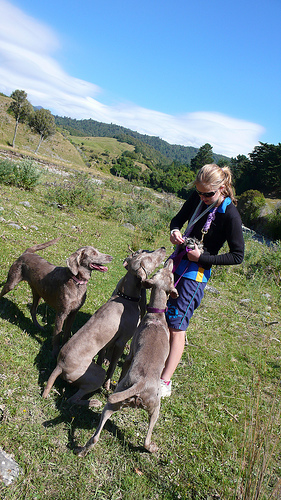

In [ ]:
from PIL import Image

Image.open('/kaggle/input/flickr8k/Images/2190227737_6e0bde2623.jpg')

Let's make a DataFrame with path to images and captions as columns.

In [ ]:
import io
import numpy as np
import pandas as pd

# Setting seed
np.random.seed(42)

# Load the captions string into a pandas DataFrame
buff = io.StringIO(captions)
df = pd.read_csv(buff)
# Construct the full path for each image file
df.image = df.image.apply (lambda im_path: os.path.join(path, 'Images', im_path))

df.head(10)

image  \
0  /kaggle/input/flickr8k/Images/1000268201_693b0...   
1  /kaggle/input/flickr8k/Images/1000268201_693b0...   
2  /kaggle/input/flickr8k/Images/1000268201_693b0...   
3  /kaggle/input/flickr8k/Images/1000268201_693b0...   
4  /kaggle/input/flickr8k/Images/1000268201_693b0...   
5  /kaggle/input/flickr8k/Images/1001773457_577c3...   
6  /kaggle/input/flickr8k/Images/1001773457_577c3...   
7  /kaggle/input/flickr8k/Images/1001773457_577c3...   
8  /kaggle/input/flickr8k/Images/1001773457_577c3...   
9  /kaggle/input/flickr8k/Images/1001773457_577c3...   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...  
5         A black dog and a spotted dog are fighting  
6  A black dog and a tri-colored dog playing with...  
7  A black dog and a white dog with brown spots a...  
8  Two dogs of different breeds looking at each o...  
9    Two dogs on pavement moving toward each other .

It looks like there are a lot of duplicates in the dataset.

In [ ]:
df = df.sort_values('image').reset_index(drop=True)

df.head(12).image.values

array(['/kaggle/input/flickr8k/Images/1000268201_693b08cb0e.jpg',
       '/kaggle/input/flickr8k/Images/1000268201_693b08cb0e.jpg',
       '/kaggle/input/flickr8k/Images/1000268201_693b08cb0e.jpg',
       '/kaggle/input/flickr8k/Images/1000268201_693b08cb0e.jpg',
       '/kaggle/input/flickr8k/Images/1000268201_693b08cb0e.jpg',
       '/kaggle/input/flickr8k/Images/1001773457_577c3a7d70.jpg',
       '/kaggle/input/flickr8k/Images/1001773457_577c3a7d70.jpg',
       '/kaggle/input/flickr8k/Images/1001773457_577c3a7d70.jpg',
       '/kaggle/input/flickr8k/Images/1001773457_577c3a7d70.jpg',
       '/kaggle/input/flickr8k/Images/1001773457_577c3a7d70.jpg',
       '/kaggle/input/flickr8k/Images/1002674143_1b742ab4b8.jpg',
       '/kaggle/input/flickr8k/Images/1002674143_1b742ab4b8.jpg'],
      dtype=object)

The dataset consists of 40455 images with captions, but only 8091 images are unique. It means that there are 5 different captions for each image.

We'll do the following:
- Set a random rank(1-5) for the image within its image group
- Marker each image that has the rank less than 5 as the one which will be used in the training process
- The rest of the images will be used for the test and validation sets

The distribution will look like this:
- 32364 for the train set
- 4046 for the test set
- 4045 for the validation set

In [ ]:
len(df), df.image.nunique(), 8091 // 2 + 1, 8091 // 2

(40455, 8091, 4046, 4045)

In [ ]:
df['random_rank'] = df.groupby('image').image.transform(
    lambda x: np.random.permutation(len(x))
)
df['is_train'] = df['random_rank'] < 4

df.head(12)

image  \
0   /kaggle/input/flickr8k/Images/1000268201_693b0...   
1   /kaggle/input/flickr8k/Images/1000268201_693b0...   
2   /kaggle/input/flickr8k/Images/1000268201_693b0...   
3   /kaggle/input/flickr8k/Images/1000268201_693b0...   
4   /kaggle/input/flickr8k/Images/1000268201_693b0...   
5   /kaggle/input/flickr8k/Images/1001773457_577c3...   
6   /kaggle/input/flickr8k/Images/1001773457_577c3...   
7   /kaggle/input/flickr8k/Images/1001773457_577c3...   
8   /kaggle/input/flickr8k/Images/1001773457_577c3...   
9   /kaggle/input/flickr8k/Images/1001773457_577c3...   
10  /kaggle/input/flickr8k/Images/1002674143_1b742...   
11  /kaggle/input/flickr8k/Images/1002674143_1b742...   

                                              caption  random_rank  is_train  
0   A child in a pink dress is climbing up a set o...            1      True  
1               A girl going into a wooden building .            4     False  
2    A little girl climbing into a wooden playhouse .            2      True  
3   A little girl climbing the stairs to her playh...            0      True  
4   A little girl in a pink dress going into a woo...            3      True  
5     Two dogs on pavement moving toward each other .            3      True  
6   A black dog and a white dog with brown spots a...            1      True  
7   Two dogs of different breeds looking at each o...            2      True  
8          A black dog and a spotted dog are fighting            0      True  
9   A black dog and a tri-colored dog playing with...            4     False  
10  A little girl covered in paint sits in front o...            1      True  
11  A little girl is sitting in front of a large p...            0      True

In [ ]:
# Check the number of samples in the train set
df.is_train.sum()

np.int64(32364)

In [ ]:
train_df = df[df.is_train]

res_df = df[~df.is_train]
res_df = res_df.sample(frac=1, random_state=42).reset_index(drop=True)

test_size = 4046
test_df = res_df.iloc[:test_size].reset_index(drop=True)
valid_df = res_df.iloc[test_size:].reset_index(drop=True)

# Check the distribution
len(train_df), len(test_df), len(valid_df)

(32364, 4046, 4045)

In [ ]:
import torch
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')
sns.set()

We'll use OpenAI GPT2 as the decoder.

**GPT-2 Overview**

`GPT-2`, which stands for `Generative Pre-trained Transformer 2`, is a powerful language model designed to generate coherent and human-like text. Unlike `BERT`, it processes text in a strictly left-to-right, autoregressive direction, allowing it to predict the next word in a sequence based only on the words that have come before it. `GPT-2` is pre-trained on a massive dataset of text from the internet with a single, elegant objective: to predict the next word given a preceding context. This focused, generative pre-training enables `GPT-2` to excel at a wide range of text generation tasks, from writing articles and completing sentences to creating conversational AI.

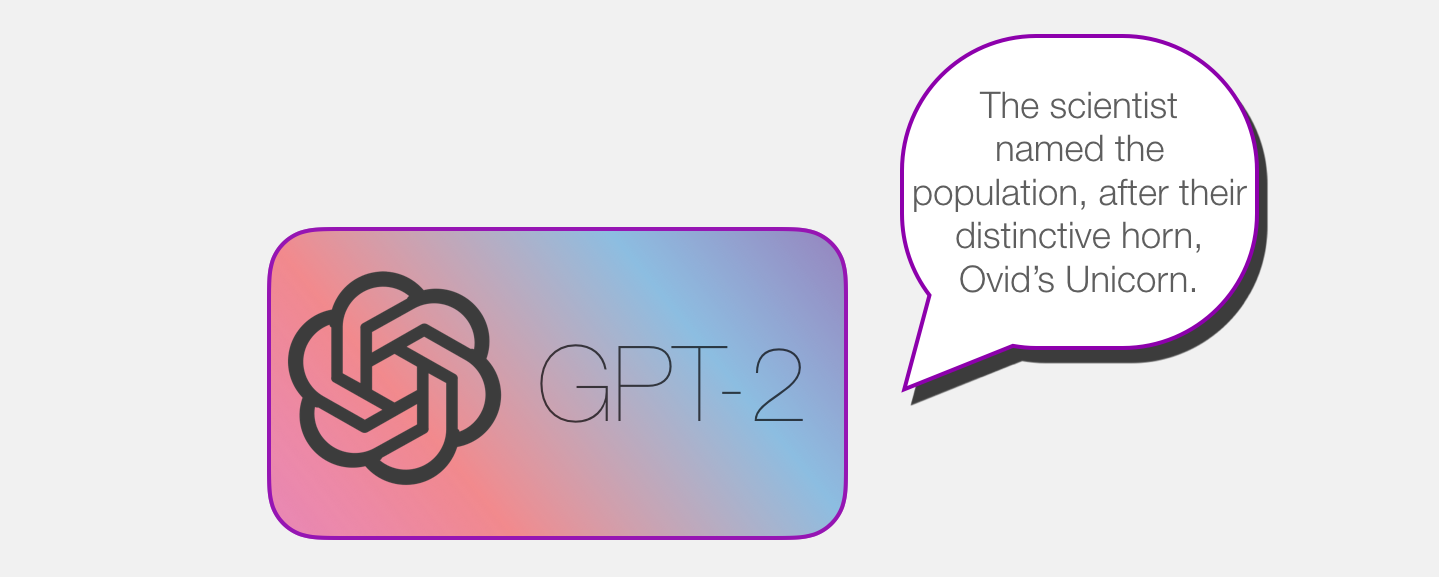

In [ ]:
from transformers import AutoTokenizer

llm_id = 'openai-community/gpt2'
tokenizer = AutoTokenizer.from_pretrained(llm_id)

tokenizer.pad_token = tokenizer.eos_token

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Let's analyze the captions to determine the maximum sequence length.

In [ ]:
def get_num_tokens(text: str) -> int:
    return len(tokenizer(text).input_ids)

df['tokens_per_description'] = df.caption.map(get_num_tokens)

df.head()

index                                              image  \
0      0  /kaggle/input/flickr8k/Images/1000268201_693b0...   
1      1  /kaggle/input/flickr8k/Images/1000268201_693b0...   
2      2  /kaggle/input/flickr8k/Images/1000268201_693b0...   
3      3  /kaggle/input/flickr8k/Images/1000268201_693b0...   
4      4  /kaggle/input/flickr8k/Images/1000268201_693b0...   

                                             caption  random_rank  is_train  \
0  A child in a pink dress is climbing up a set o...            1      True   
1              A girl going into a wooden building .            4     False   
2   A little girl climbing into a wooden playhouse .            2      True   
3  A little girl climbing the stairs to her playh...            0      True   
4  A little girl in a pink dress going into a woo...            3      True   

   tokens_per_description  
0                      18  
1                       8  
2                      10  
3                      11  
4                      13

In [ ]:
df.tokens_per_description.max()

41

The longest caption is 41 tokens long. We'll save this value for later.

In [ ]:
from torch.utils.data import Dataset


class ImageCaptionDataset(Dataset):
    """Dataset that returns prcessed images with LVM processor and LLM tokenizer"""

    def __init__(self, df, processor, tokenizer, max_length=41):
        self.images = df.image.values.tolist()
        self.captions = df.caption.values.tolist()
        self.processor = processor
        self.tokenizer = tokenizer
        # Tokens from the text + <|endoftext|> token
        self.max_length = max_length + 1

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Reading the image and getting pixel values
        image = Image.open(self.images[idx]).convert('RGB')
        im_inputs = self.processor(images=image, return_tensors='pt')
        pixel_values = im_inputs['pixel_values'].squeeze(0)

        # Tokenizing the caption and getting input ids
        caption = self.captions[idx]
        text_inputs = self.tokenizer(
            caption,
            add_special_tokens=True,
            padding='max_length',
            max_length=self.max_length
        )

        input_ids = torch.tensor(text_inputs.input_ids)
        input_ids[input_ids == tokenizer.pad_token_id] = -100

        return pixel_values, input_ids

There are two important points to note about the code above:
- We set `max_length` 41 based on our analysis
- We replace all `input_ids` that are equal to `GPT-2` `[PAD]` token id with `-100` because torch uses this constant as the marker to ignore these specific tokens during loss calculation

Let's load our `LVM(Swin Transformer V2)` and then create the datasets.

In [ ]:
from transformers import AutoImageProcessor

lvm_id = 'microsoft/swinv2-base-patch4-window16-256'
processor = AutoImageProcessor.from_pretrained(lvm_id, use_fast=True)

train_ds = ImageCaptionDataset(train_df, processor, tokenizer)
test_ds = ImageCaptionDataset(test_df, processor, tokenizer)
valid_ds = ImageCaptionDataset(valid_df, processor, tokenizer)

preprocessor_config.json:   0%|          | 0.00/240 [00:00<?, ?B/s]

**Swin Transformer V2 Overview**

`Swin Transformer V2` is an enhanced vision transformer that builds upon its predecessor to handle larger models and higher-resolution images more effectively. It processes images in a hierarchical manner, starting with local attention within non-overlapping windows of image patches and then progressively merging these patches and shifting the windows to learn broader, more global features. To improve training stability with larger models, it introduces a scaled cosine attention mechanism. Furthermore, it employs a log-spaced continuous position bias, allowing the model to effectively adapt to different image resolutions between pre-training and fine-tuning. This combination of windowed attention and architectural improvements enables `Swin Transformer V2` to achieve state-of-the-art performance on various computer vision tasks.

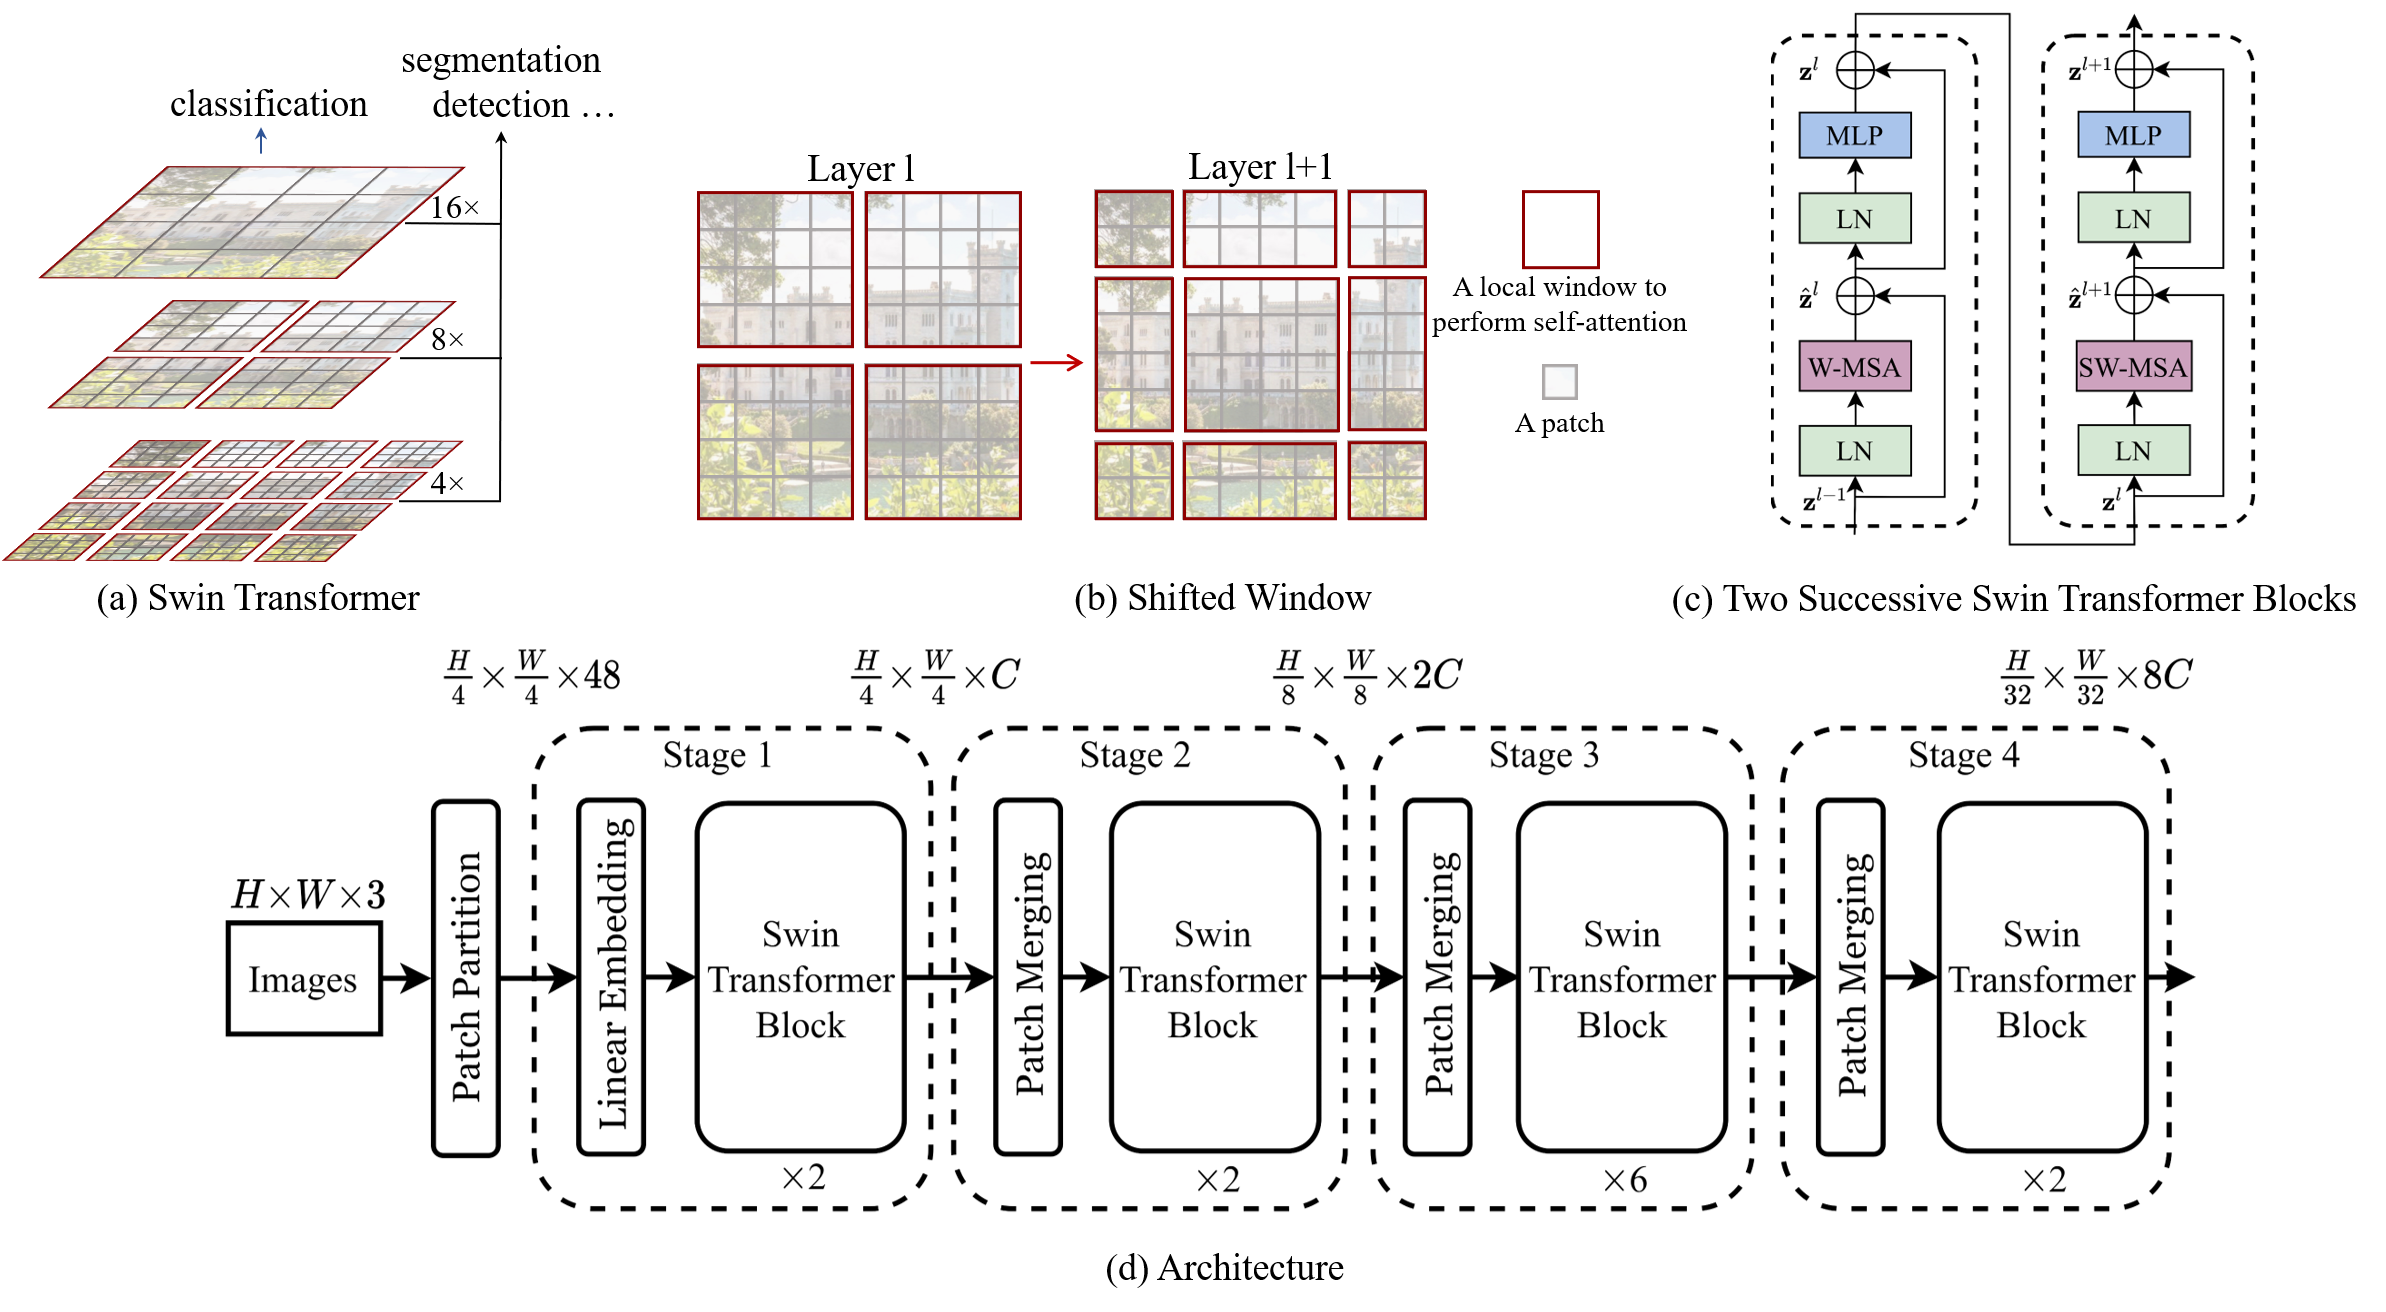

In [ ]:
# Verify the output of the dataset
train_ds[0]

(tensor([[[-0.8164, -0.2171,  0.0056,  ..., -2.0494, -2.0152, -2.0323],
          [-0.8678, -0.1828,  0.0227,  ..., -1.9980, -1.9809, -1.9295],
          [-0.9020, -0.1314,  0.0056,  ..., -1.9809, -2.0152, -1.8610],
          ...,
          [ 1.0673,  0.0056,  0.5878,  ...,  1.1187,  0.6906,  0.7077],
          [ 0.9817,  1.2043,  1.8893,  ...,  1.0331,  0.7419,  0.7591],
          [ 1.4269,  1.6495,  0.6563,  ...,  0.9474,  0.7419,  0.7762]],
 
         [[-0.6176,  0.2227,  0.4328,  ..., -2.0007, -1.9132, -1.9132],
          [-0.6877,  0.2227,  0.4853,  ..., -1.9307, -1.8606, -1.7381],
          [-0.7752,  0.2752,  0.4503,  ..., -1.8782, -1.7906, -1.4930],
          ...,
          [-0.1625, -1.1429, -0.0924,  ...,  1.4832,  1.1506,  1.1856],
          [-0.3725,  0.7129,  1.2206,  ...,  1.3957,  1.1681,  1.1856],
          [ 0.0826,  0.7129, -0.4601,  ...,  1.3081,  1.1681,  1.1856]],
 
         [[-0.1835,  0.3393,  0.6705,  ..., -1.7696, -1.7173, -1.7347],
          [-0.3055,  0.3742,

The datasets are ready, now we need to define the dataloaders.

In [ ]:
from torch.utils.data import DataLoader

batch_size = 32
cpu_count = os.cpu_count() # 12
params = dict(
    shuffle=True,
    batch_size=batch_size,
    num_workers=cpu_count,
    pin_memory=True
)

train_dl = DataLoader(train_ds, **params)
test_dl = DataLoader(test_ds, **params)
valid_dl = DataLoader(valid_ds, **params)

In the code above, we set up parallel processing for data loading by setting `num_workers` to the number of available CPU cores, which helps speed things up. We also optimized data transfer from the CPU to the GPU by setting `pin_memory` to `True`.

Now we need to download the full model.

In [ ]:
from transformers import VisionEncoderDecoderModel


model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(lvm_id, llm_id)

# ids
model.config.decoder_start_token_id = tokenizer.cls_token_id
model.config.pad_token_id = tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size
# set beam search parameters
model.config.eos_token_id = tokenizer.sep_token_id
model.config.decoder_start_token_id = tokenizer.bos_token_id
model.config.max_length = 41
model.config.no_repeat_ngram_size = 3
model.config.num_beams = 1

config.json:   0%|          | 0.00/69.9k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/352M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/352M [00:00<?, ?B/s]

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at openai-community/gpt2 and are newly initialized: ['transformer.h.0.crossattention.c_attn.bias', 'transformer.h.0.crossattention.c_attn.weight', 'transformer.h.0.crossattention.c_proj.bias', 'transformer.h.0.crossattention.c_proj.weight', 'transformer.h.0.crossattention.q_attn.bias', 'transformer.h.0.crossattention.q_attn.weight', 'transformer.h.0.ln_cross_attn.bias', 'transformer.h.0.ln_cross_attn.weight', 'transformer.h.1.crossattention.c_attn.bias', 'transformer.h.1.crossattention.c_attn.weight', 'transformer.h.1.crossattention.c_proj.bias', 'transformer.h.1.crossattention.c_proj.weight', 'transformer.h.1.crossattention.q_attn.bias', 'transformer.h.1.crossattention.q_attn.weight', 'transformer.h.1.ln_cross_attn.bias', 'transformer.h.1.ln_cross_attn.weight', 'transformer.h.10.crossattention.c_attn.bias', 'transformer.h.10.crossattention.c_attn.weight', 'transformer.h.10.crossattention.c_proj.bias', 'tran

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:
model

VisionEncoderDecoderModel(
  (encoder): Swinv2Model(
    (embeddings): Swinv2Embeddings(
      (patch_embeddings): Swinv2PatchEmbeddings(
        (projection): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      )
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): Swinv2Encoder(
      (layers): ModuleList(
        (0): Swinv2Stage(
          (blocks): ModuleList(
            (0): Swinv2Layer(
              (attention): Swinv2Attention(
                (self): Swinv2SelfAttention(
                  (continuous_position_bias_mlp): Sequential(
                    (0): Linear(in_features=2, out_features=512, bias=True)
                    (1): ReLU(inplace=True)
                    (2): Linear(in_features=512, out_features=4, bias=False)
                  )
                  (query): Linear(in_features=128, out_features=128, bias=True)
                  (key): Linear(in_features=128, out_features=128, 

We have the data loaders and the model. Now, we need to define the remaining training components, such as the optimizer, number of training epochs, learning rate scheduler, compute device, and the `ROUGE score` for our evaluation metric.

In [ ]:
import evaluate
from torch.optim import AdamW
from transformers import get_scheduler

epochs = 30
optimizer = AdamW(model.parameters(), lr=5e-5)
num_training_steps = epochs * len(train_dl)
num_warmup_steps = num_training_steps // 5

scheduler = get_scheduler(name='linear', optimizer=optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

metric = evaluate.load('rouge')

Everything is set up, now we may implement some extra functions for the training process.

In [ ]:
from tqdm import tqdm

def evaluate_with_rouge(model, dl, tokenizer, metric, device):
    """
    Method to evaluate model's performance on a given dataset using the ROUGE metric

    :param model: The model to evaluate
    :param dl: The DataLoader for the evaluation data
    :param tokenizer: The tokenizer used to decode predictions and labels
    :param metric: The ROUGE metric object from the `evaluate` library
    :param device: The device for evaluation
    :return: A dictionary with the computed metrics: rouge1, rouge2, rougeL and rougeLsum
    """
    model.eval()

    progress_bar = tqdm(dl, desc='Calculating Rouge', leave=False)

    for pixel_values, input_ids in progress_bar:
        pixel_values = pixel_values.to(device)
        labels = input_ids.to(device)

        # Disable gradient calculation for faster and less memory-intensive inference
        with torch.no_grad():
            outputs = model(
                pixel_values=pixel_values,
                labels=labels
            )

        # Get the most likely token ID for each position in the sequence
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)

        # Decode the predicted token IDs into text
        predictions = tokenizer.batch_decode(predictions, skip_special_tokens=True)
        # Minor cleanup on the predictions to improve scoring alignment
        predictions = [pred_caption.replace('.', '') for pred_caption in predictions]
        # Labels use -100 to mask padding, replace with [PAD] token id for correct decoding
        references = [
            tokenizer.decode(
                [tokenizer.pad_token_id if token == -100 else token for token in reference],
                skip_special_tokens=True
            )
            for reference in labels.tolist()
        ]
        # Add the current batch of predictions and references to the metric accumulator
        metric.add_batch(predictions=predictions, references=references)

    return metric.compute()

In [ ]:
def train_one_epoch(model, dl, optimizer, scheduler, device, tokenizer, metric):
    """
    Function that trains the model for a single epoch

    :param model: The model to be trained
    :param dl: DataLoader for the training data
    :param optimizer: The optimizer for updating model weights
    :param scheduler: The learning rate scheduler
    :param device: The device for training
    :param tokenizer: GPT-2 tokenizer for decoding
    :param metric: The metric object to evaluate rouge1, rouge2, rougeL and rougeLsum
    :return: A dictionary with loss and computed metrics: rouge1, rouge2, rougeL and rougeLsum
    """
    model.train()

    total_loss = 0
    progress_bar = tqdm(dl, desc='Training', leave=False)

    for pixel_values, input_ids in progress_bar:
        # Move data to the specified computation device.
        pixel_values = pixel_values.to(device)
        labels = input_ids.to(device)

        # Perform a forward pass through the model.
        # The model returns outputs including the loss.
        outputs = model(
            pixel_values=pixel_values,
            labels=labels
        )
        loss = outputs.loss

        # Backpropagation: compute gradients, update weights, and clear gradients.
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        # Update the progress bar with the loss for the current batch.
        progress_bar.set_postfix(loss=loss.item())

        total_loss += loss.item()

    # Calculate the average loss over all batches.
    avg_loss = total_loss / len(dl)

    # Evaluate the model on the training data at the end of the epoch.
    rouge_scores = evaluate_with_rouge(model, dl, tokenizer, metric, device)

    return {'loss': avg_loss, **rouge_scores}

In [ ]:
def evaluate(model, dl, device, tokenizer, metric):
    """
    Method to evaluate the model on a given dataset

    :param model: The model to evaluate
    :param dl: DataLoader for the evaluation data
    :param device: The device for evaluation
    :param tokenizer: GPT-2 tokenizer for decoding predictions
    :param metric: The metric object to evaluate rouge1, rouge2, rougeL and rougeLsum
    :return: A dictionary with loss and computed metrics: rouge1, rouge2, rougeL and rougeLsum
    """
    model.eval()

    total_loss = 0
    progress_bar = tqdm(dl, desc='Evaluating', leave=False)

    for pixel_values, input_ids in progress_bar:
        pixel_values = pixel_values.to(device)
        labels = input_ids.to(device)

        # Disable gradient calculation for inference.
        with torch.no_grad():
            outputs = model(
                pixel_values=pixel_values,
                labels=labels
            )

        # Accumulate the loss for the batch.
        loss = outputs.loss
        total_loss += loss.item()

        # Update the progress bar with the current batch's loss.
        progress_bar.set_postfix(loss=loss.item())

    # Calculate the average loss across all batches.
    avg_loss = total_loss / len(dl)

    # Use the separate function to get ROUGE scores for the whole dataset.
    rouge_scores = evaluate_with_rouge(model, dl, tokenizer, metric, device)

    # Return a dictionary with the average loss and the ROUGE scores.
    return {'loss': avg_loss, **rouge_scores}

In [ ]:
class History:
    """Plcaholder to store training metrics and loss in a structured format"""

    def __init__(self):
        self._history = {'loss': [], 'rouge1': [], 'rouge2': [], 'rougeL': [], 'rougeLsum': []}

    def update(self, metrics):
        self._history ['loss'].append(metrics.get('loss', 0.0))
        self._history ['rouge1'].append(metrics.get('rouge1', 0.0))
        self._history ['rouge2'].append(metrics.get('rouge2', 0.0))
        self._history ['rougeL'].append(metrics.get('rougeL', 0.0))
        self._history ['rougeLsum'].append(metrics.get('rougeLsum', 0.0))

    def to_df(self):
        return pd.DataFrame(self._history)

    @property
    def hist_metrics(self):
        return self._history

We have all necessary stuff to start the training. So, let's do it!

In [ ]:
train_history = History()
test_history = History()

for epoch in range(1, epochs + 1):
    print(f'Epoch {epoch}/{epochs}')

    train_metrics = train_one_epoch(model, train_dl, optimizer, scheduler, device, tokenizer, metric)
    test_metrics = evaluate(model, test_dl, device, tokenizer, metric)

    print(f"Train | Loss: {train_metrics['loss']:.3f} | Rouge1: {train_metrics['rouge1']:.5f} | Rouge2: {train_metrics['rouge2']:.5f} | RougeL: {train_metrics['rougeL']:.5f} | RougeLsum: {train_metrics['rougeLsum']:.5f}")
    print(f" Test | Loss: {test_metrics['loss']:.3f} | Rouge1: {test_metrics['rouge1']:.5f} | Rouge2: {test_metrics['rouge2']:.5f} | RougeL: {test_metrics['rougeL']:.5f} | RougeLsum: {test_metrics['rougeLsum']:.5f}\n")

    train_history.update(train_metrics)
    test_history.update(test_metrics)

    model.save_pretrained(f'model_epoch_{epoch}')

Epoch 1/30


Training:   0%|          | 0/1012 [00:00<?, ?it/s]`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Train | Loss: 5.857 | Rouge1: 0.14612 | Rouge2: 0.01800 | RougeL: 0.11628 | RougeLsum: 0.11629
 Test | Loss: 4.468 | Rouge1: 0.14587 | Rouge2: 0.01754 | RougeL: 0.11620 | RougeLsum: 0.11624

Epoch 2/30


Train | Loss: 4.301 | Rouge1: 0.16560 | Rouge2: 0.03153 | RougeL: 0.13058 | RougeLsum: 0.13053
 Test | Loss: 3.955 | Rouge1: 0.16338 | Rouge2: 0.03036 | RougeL: 0.12921 | RougeLsum: 0.12917

Epoch 3/30


Train | Loss: 3.907 | Rouge1: 0.17562 | Rouge2: 0.04096 | RougeL: 0.14078 | RougeLsum: 0.14077
 Test | Loss: 3.671 | Rouge1: 0.17142 | Rouge2: 0.03742 | RougeL: 0.13672 | RougeLsum: 0.13672

Epoch 4/30


Train | Loss: 3.631 | Rouge1: 0.18743 | Rouge2: 0.04969 | RougeL: 0.15144 | RougeLsum: 0.15146
 Test | Loss: 3.506 | Rouge1: 0.17975 | Rouge2: 0.04367 | RougeL: 0.14445 | RougeLsum: 0.14457

Epoch 5/30


Train | Loss: 3.383 | Rouge1: 0.19723 | Rouge2: 0.05734 | RougeL: 0.16066 | RougeLsum: 0.16063
 Test | Loss: 3.388 | Rouge1: 0.18488 | Rouge2: 0.04915 | RougeL: 0.14942 | RougeLsum: 0.14944

Epoch 6/30


Train | Loss: 3.171 | Rouge1: 0.21364 | Rouge2: 0.06612 | RougeL: 0.17633 | RougeLsum: 0.17634
 Test | Loss: 3.319 | Rouge1: 0.19350 | Rouge2: 0.05137 | RougeL: 0.15750 | RougeLsum: 0.15747

Epoch 7/30


Train | Loss: 2.961 | Rouge1: 0.22396 | Rouge2: 0.07487 | RougeL: 0.18526 | RougeLsum: 0.18524
 Test | Loss: 3.275 | Rouge1: 0.19622 | Rouge2: 0.05331 | RougeL: 0.15932 | RougeLsum: 0.15937

Epoch 8/30


Train | Loss: 2.743 | Rouge1: 0.23602 | Rouge2: 0.08516 | RougeL: 0.19766 | RougeLsum: 0.19763
 Test | Loss: 3.259 | Rouge1: 0.19723 | Rouge2: 0.05282 | RougeL: 0.16046 | RougeLsum: 0.16046

Epoch 9/30


Train | Loss: 2.542 | Rouge1: 0.25243 | Rouge2: 0.09845 | RougeL: 0.21399 | RougeLsum: 0.21401
 Test | Loss: 3.283 | Rouge1: 0.20339 | Rouge2: 0.05651 | RougeL: 0.16701 | RougeLsum: 0.16710

Epoch 10/30


Train | Loss: 2.353 | Rouge1: 0.26346 | Rouge2: 0.11153 | RougeL: 0.22660 | RougeLsum: 0.22659
 Test | Loss: 3.325 | Rouge1: 0.20011 | Rouge2: 0.05469 | RougeL: 0.16334 | RougeLsum: 0.16334

Epoch 11/30


Train | Loss: 2.172 | Rouge1: 0.27989 | Rouge2: 0.12955 | RougeL: 0.24288 | RougeLsum: 0.24290
 Test | Loss: 3.426 | Rouge1: 0.20174 | Rouge2: 0.05563 | RougeL: 0.16505 | RougeLsum: 0.16502

Epoch 12/30


Train | Loss: 2.004 | Rouge1: 0.30198 | Rouge2: 0.14966 | RougeL: 0.26544 | RougeLsum: 0.26541
 Test | Loss: 3.505 | Rouge1: 0.20837 | Rouge2: 0.05844 | RougeL: 0.17178 | RougeLsum: 0.17176

Epoch 13/30


Train | Loss: 1.845 | Rouge1: 0.31265 | Rouge2: 0.16647 | RougeL: 0.27872 | RougeLsum: 0.27868
 Test | Loss: 3.639 | Rouge1: 0.20416 | Rouge2: 0.05466 | RougeL: 0.16848 | RougeLsum: 0.16849

Epoch 14/30


Train | Loss: 1.703 | Rouge1: 0.32433 | Rouge2: 0.18598 | RougeL: 0.29311 | RougeLsum: 0.29315
 Test | Loss: 3.760 | Rouge1: 0.20184 | Rouge2: 0.05451 | RougeL: 0.16624 | RougeLsum: 0.16625

Epoch 15/30


Train | Loss: 1.569 | Rouge1: 0.33168 | Rouge2: 0.20273 | RougeL: 0.30324 | RougeLsum: 0.30322
 Test | Loss: 3.919 | Rouge1: 0.19860 | Rouge2: 0.05371 | RougeL: 0.16473 | RougeLsum: 0.16470

Epoch 16/30


Train | Loss: 1.446 | Rouge1: 0.34870 | Rouge2: 0.22302 | RougeL: 0.31891 | RougeLsum: 0.31892
 Test | Loss: 4.057 | Rouge1: 0.20004 | Rouge2: 0.05208 | RougeL: 0.16409 | RougeLsum: 0.16401

Epoch 17/30


Train | Loss: 1.335 | Rouge1: 0.35714 | Rouge2: 0.23807 | RougeL: 0.32954 | RougeLsum: 0.32950
 Test | Loss: 4.165 | Rouge1: 0.20009 | Rouge2: 0.05266 | RougeL: 0.16486 | RougeLsum: 0.16484

Epoch 18/30


Train | Loss: 1.240 | Rouge1: 0.37503 | Rouge2: 0.26191 | RougeL: 0.34853 | RougeLsum: 0.34855
 Test | Loss: 4.307 | Rouge1: 0.20300 | Rouge2: 0.05322 | RougeL: 0.16808 | RougeLsum: 0.16806

Epoch 19/30


Train | Loss: 1.148 | Rouge1: 0.36963 | Rouge2: 0.26517 | RougeL: 0.34389 | RougeLsum: 0.34390
 Test | Loss: 4.413 | Rouge1: 0.19845 | Rouge2: 0.05174 | RougeL: 0.16295 | RougeLsum: 0.16273

Epoch 20/30


Train | Loss: 1.073 | Rouge1: 0.38143 | Rouge2: 0.28224 | RougeL: 0.35729 | RougeLsum: 0.35727
 Test | Loss: 4.572 | Rouge1: 0.19880 | Rouge2: 0.05136 | RougeL: 0.16376 | RougeLsum: 0.16373

Epoch 21/30


Train | Loss: 1.002 | Rouge1: 0.38596 | Rouge2: 0.29130 | RougeL: 0.36198 | RougeLsum: 0.36201
 Test | Loss: 4.646 | Rouge1: 0.19877 | Rouge2: 0.05132 | RougeL: 0.16307 | RougeLsum: 0.16307

Epoch 22/30


Train | Loss: 0.941 | Rouge1: 0.38774 | Rouge2: 0.29790 | RougeL: 0.36446 | RougeLsum: 0.36439
 Test | Loss: 4.728 | Rouge1: 0.19614 | Rouge2: 0.05065 | RougeL: 0.16097 | RougeLsum: 0.16102

Epoch 23/30


Train | Loss: 0.885 | Rouge1: 0.39138 | Rouge2: 0.30584 | RougeL: 0.36896 | RougeLsum: 0.36897
 Test | Loss: 4.827 | Rouge1: 0.19565 | Rouge2: 0.04992 | RougeL: 0.16046 | RougeLsum: 0.16053

Epoch 24/30


Train | Loss: 0.837 | Rouge1: 0.39260 | Rouge2: 0.31045 | RougeL: 0.37089 | RougeLsum: 0.37088
 Test | Loss: 4.918 | Rouge1: 0.19442 | Rouge2: 0.04921 | RougeL: 0.15864 | RougeLsum: 0.15864

Epoch 25/30


Train | Loss: 0.792 | Rouge1: 0.39666 | Rouge2: 0.31700 | RougeL: 0.37512 | RougeLsum: 0.37505
 Test | Loss: 4.994 | Rouge1: 0.19438 | Rouge2: 0.04942 | RougeL: 0.15900 | RougeLsum: 0.15907

Epoch 26/30


Train | Loss: 0.754 | Rouge1: 0.39922 | Rouge2: 0.32123 | RougeL: 0.37793 | RougeLsum: 0.37794
 Test | Loss: 5.068 | Rouge1: 0.19525 | Rouge2: 0.04897 | RougeL: 0.15904 | RougeLsum: 0.15896

Epoch 27/30


Train | Loss: 0.720 | Rouge1: 0.40097 | Rouge2: 0.32351 | RougeL: 0.37897 | RougeLsum: 0.37897
 Test | Loss: 5.125 | Rouge1: 0.19541 | Rouge2: 0.04898 | RougeL: 0.15901 | RougeLsum: 0.15889

Epoch 28/30


Train | Loss: 0.688 | Rouge1: 0.40013 | Rouge2: 0.32530 | RougeL: 0.37915 | RougeLsum: 0.37907
 Test | Loss: 5.183 | Rouge1: 0.19293 | Rouge2: 0.04821 | RougeL: 0.15730 | RougeLsum: 0.15722

Epoch 29/30


Train | Loss: 0.663 | Rouge1: 0.40240 | Rouge2: 0.32809 | RougeL: 0.38137 | RougeLsum: 0.38142
 Test | Loss: 5.224 | Rouge1: 0.19410 | Rouge2: 0.04860 | RougeL: 0.15772 | RougeLsum: 0.15763

Epoch 30/30


Train | Loss: 0.644 | Rouge1: 0.40308 | Rouge2: 0.32907 | RougeL: 0.38201 | RougeLsum: 0.38198
 Test | Loss: 5.251 | Rouge1: 0.19416 | Rouge2: 0.04833 | RougeL: 0.15783 | RougeLsum: 0.15785



In [ ]:
train_history.to_df()

loss    rouge1    rouge2    rougeL  rougeLsum
0   5.856568  0.146119  0.018001  0.116280   0.116292
1   4.301204  0.165600  0.031533  0.130583   0.130530
2   3.907310  0.175618  0.040958  0.140776   0.140774
3   3.631282  0.187431  0.049687  0.151439   0.151455
4   3.382703  0.197226  0.057343  0.160661   0.160632
5   3.171014  0.213645  0.066125  0.176325   0.176342
6   2.961358  0.223962  0.074867  0.185259   0.185242
7   2.743107  0.236022  0.085157  0.197660   0.197629
8   2.541792  0.252428  0.098448  0.213989   0.214006
9   2.353126  0.263464  0.111533  0.226604   0.226595
10  2.171623  0.279885  0.129550  0.242880   0.242904
11  2.003688  0.301981  0.149656  0.265444   0.265408
12  1.844914  0.312648  0.166469  0.278721   0.278685
13  1.703148  0.324331  0.185975  0.293110   0.293151
14  1.568529  0.331685  0.202730  0.303238   0.303225
15  1.446225  0.348699  0.223018  0.318912   0.318921
16  1.334777  0.357141  0.238071  0.329539   0.329498
17  1.240282  0.375033  0.261915  0.348532   0.348551
18  1.148091  0.369626  0.265172  0.343889   0.343900
19  1.072506  0.381433  0.282241  0.357286   0.357269
20  1.001897  0.385963  0.291298  0.361978   0.362007
21  0.941477  0.387742  0.297898  0.364464   0.364394
22  0.885026  0.391380  0.305844  0.368955   0.368973
23  0.836664  0.392605  0.310448  0.370891   0.370878
24  0.791934  0.396657  0.316996  0.375123   0.375051
25  0.753734  0.399223  0.321233  0.377931   0.377936
26  0.720174  0.400969  0.323513  0.378971   0.378970
27  0.688320  0.400125  0.325297  0.379146   0.379070
28  0.663362  0.402399  0.328087  0.381368   0.381424
29  0.643579  0.403076  0.329075  0.382012   0.381976

In [ ]:
test_history.to_df()

loss    rouge1    rouge2    rougeL  rougeLsum
0   4.467686  0.145872  0.017538  0.116203   0.116241
1   3.954775  0.163384  0.030361  0.129214   0.129168
2   3.671119  0.171417  0.037423  0.136720   0.136723
3   3.505965  0.179745  0.043672  0.144452   0.144566
4   3.388481  0.184882  0.049149  0.149417   0.149436
5   3.319021  0.193498  0.051371  0.157498   0.157467
6   3.275489  0.196216  0.053309  0.159322   0.159369
7   3.258709  0.197233  0.052816  0.160462   0.160456
8   3.283092  0.203386  0.056507  0.167011   0.167104
9   3.325030  0.200107  0.054691  0.163338   0.163342
10  3.425960  0.201739  0.055629  0.165048   0.165022
11  3.505327  0.208365  0.058443  0.171778   0.171757
12  3.639149  0.204156  0.054657  0.168477   0.168490
13  3.760031  0.201840  0.054508  0.166236   0.166252
14  3.919347  0.198599  0.053711  0.164725   0.164703
15  4.056914  0.200042  0.052083  0.164088   0.164009
16  4.164655  0.200095  0.052661  0.164863   0.164843
17  4.306584  0.202997  0.053222  0.168076   0.168056
18  4.412614  0.198446  0.051743  0.162954   0.162726
19  4.571648  0.198797  0.051364  0.163763   0.163730
20  4.646321  0.198774  0.051323  0.163067   0.163072
21  4.728142  0.196141  0.050655  0.160970   0.161020
22  4.826688  0.195649  0.049923  0.160459   0.160527
23  4.918029  0.194424  0.049213  0.158636   0.158642
24  4.994463  0.194375  0.049422  0.159001   0.159075
25  5.068379  0.195251  0.048965  0.159042   0.158957
26  5.125227  0.195410  0.048981  0.159010   0.158892
27  5.182927  0.192932  0.048209  0.157303   0.157224
28  5.223974  0.194096  0.048603  0.157718   0.157627
29  5.251287  0.194163  0.048334  0.157832   0.157853

In [ ]:
pd.DataFrame(evaluate(model, train_dl, device, tokenizer, metric), index=['Train Metrics']).T

Train Metrics
loss            0.346543
rouge1          0.403028
rouge2          0.329021
rougeL          0.381918
rougeLsum       0.381942

In [ ]:
pd.DataFrame(evaluate(model, test_dl, device, tokenizer, metric), index=['Test Metrics']).T

Test Metrics
loss           5.247738
rouge1         0.194286
rouge2         0.048393
rougeL         0.157921
rougeLsum      0.157958

In [ ]:
pd.DataFrame(evaluate(model, valid_dl, device, tokenizer, metric), index=['Validation Metrics']).T

Validation Metrics
loss                 5.334666
rouge1               0.194315
rouge2               0.049829
rougeL               0.158766
rougeLsum            0.158682

As we can see, the model is extremely overfitted to the training dataset with `Swin V2 + GPT-2` as well. This is likely because the training, test and validation sets use the same images, but with different captions. Now, let's see how the model generates captions.

In [ ]:
model.eval()

In [ ]:
pixel_values = train_ds[3][0].unsqueeze(0)

# Trying to generate a caption
predictions = tokenizer.decode(model.generate(pixel_values=pixel_values.to(device))[0], num_beams=1, skip_special_tokens=True)
caption = predictions.replace('.', '')

caption

' little climbing in of wooden  hall of play  girl out the  get in window get out get out jars get  are doors enter  girl cabin  enter play  enter cabin  open play '

In [ ]:
# Select random images from the validation set
ids = np.random.choice(np.arange(len(valid_dl)), 15, replace=False)

ids

array([125,  26, 119,  61, 102, 101,  23,  42, 111,  97, 122,  48,  54,
        16,  95])

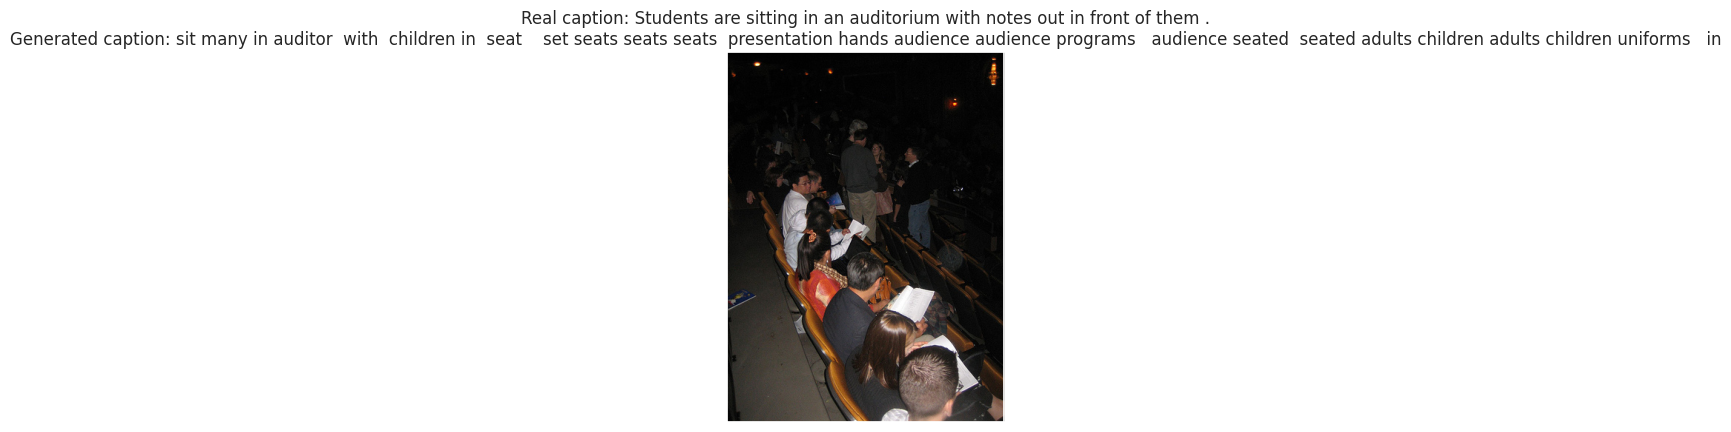

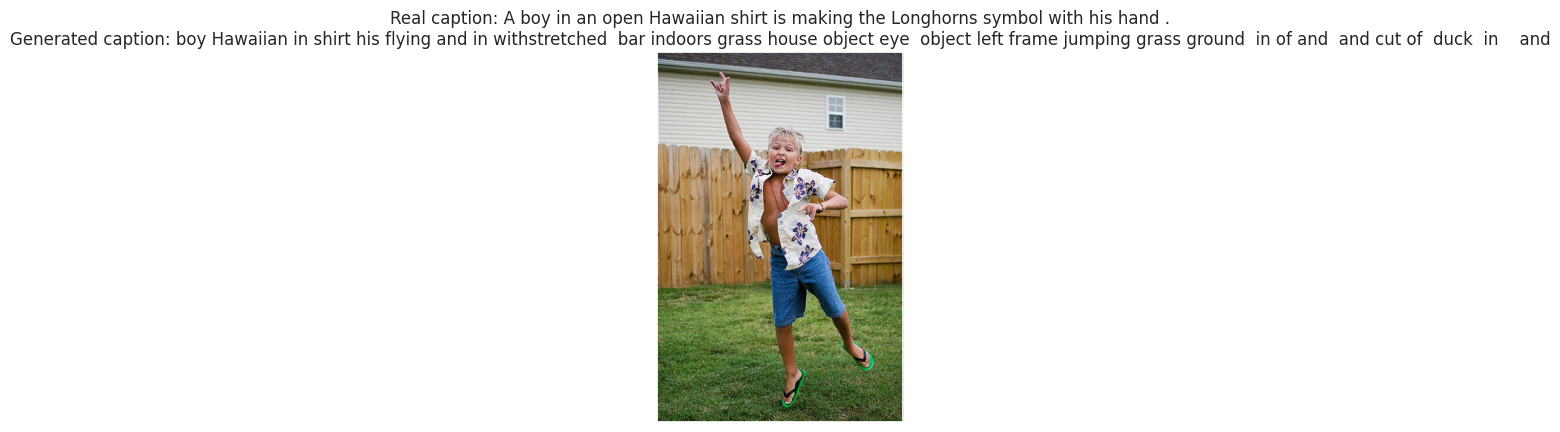

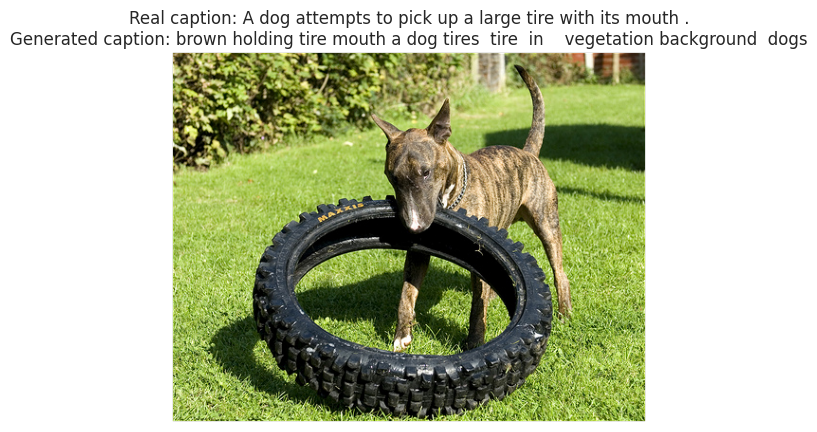

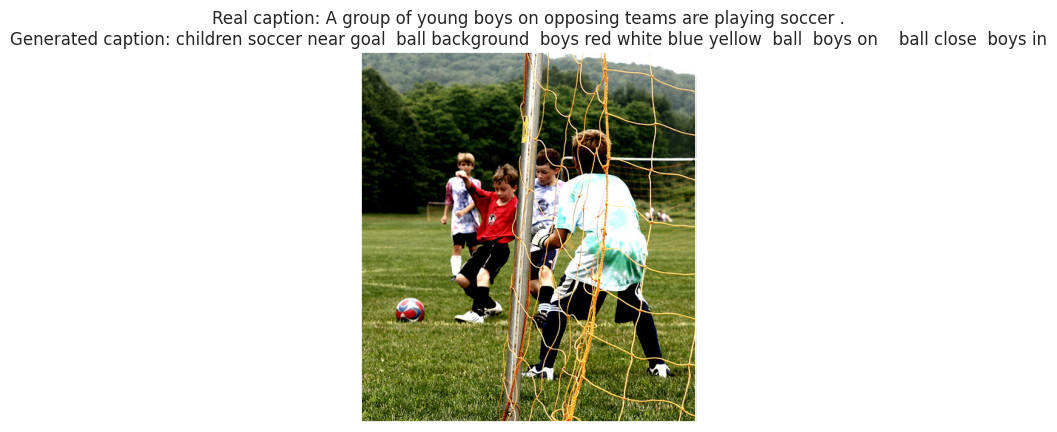

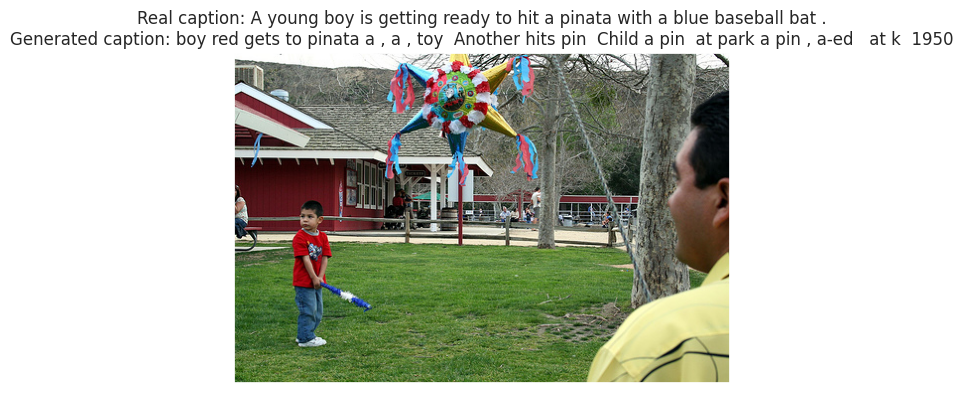

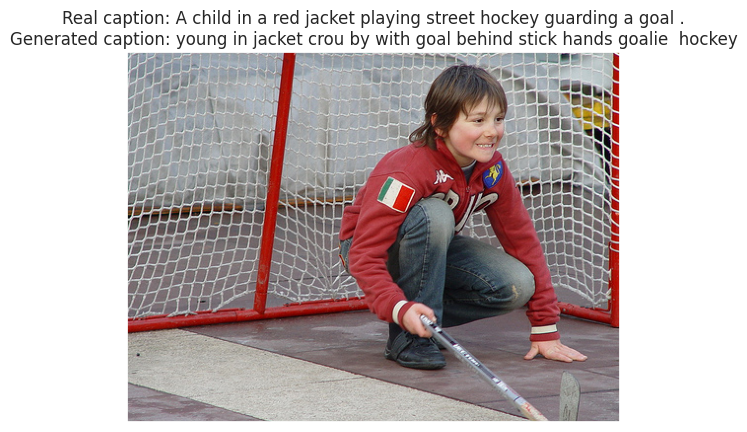

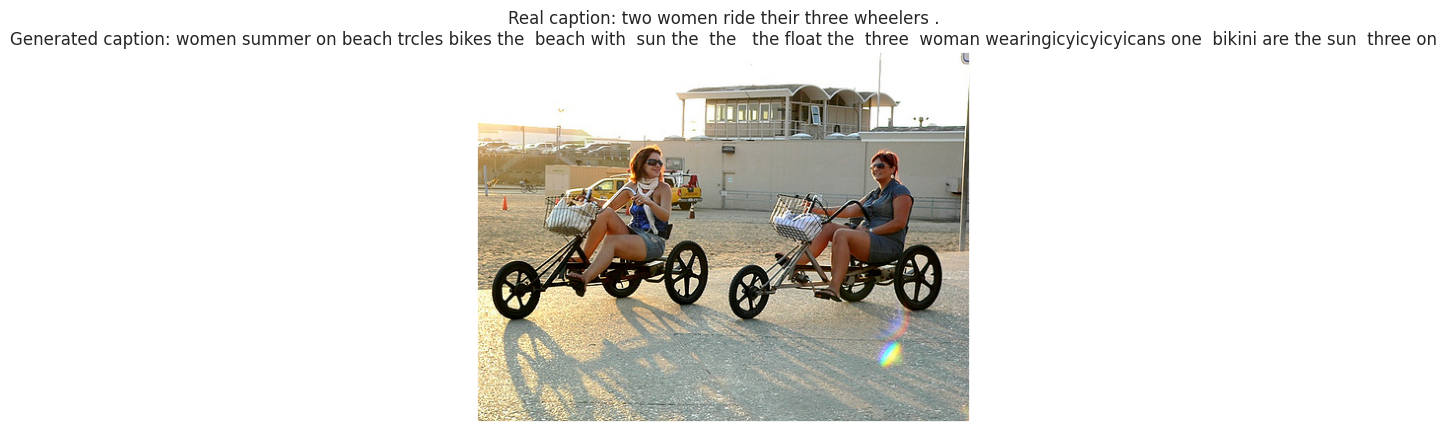

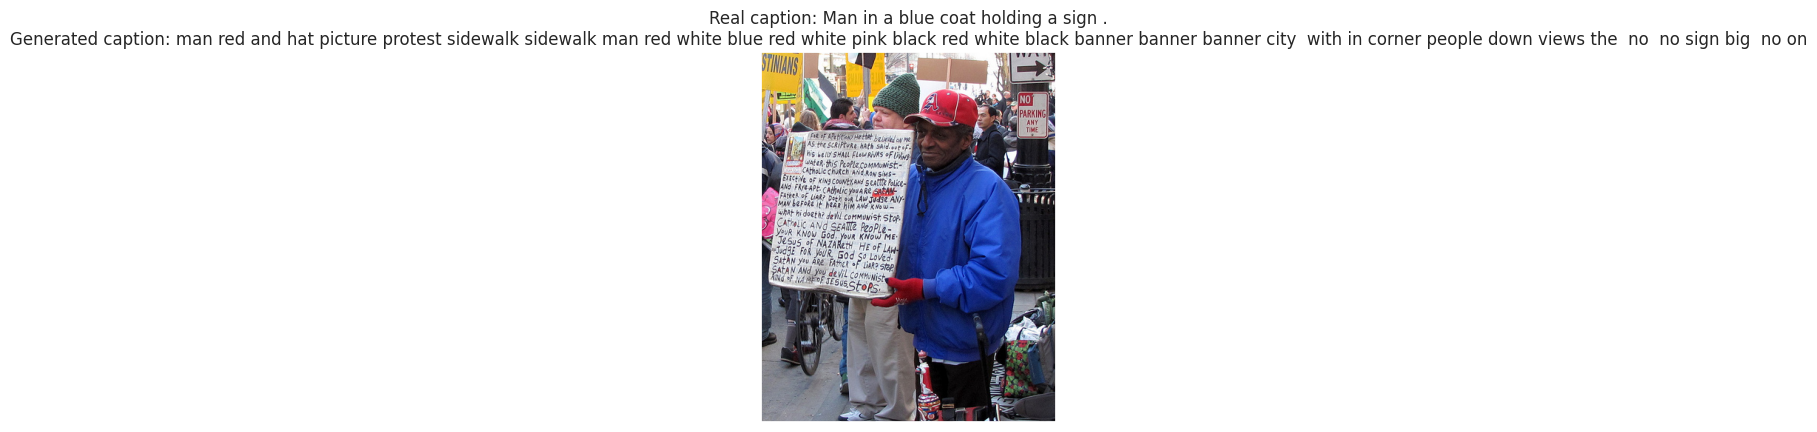

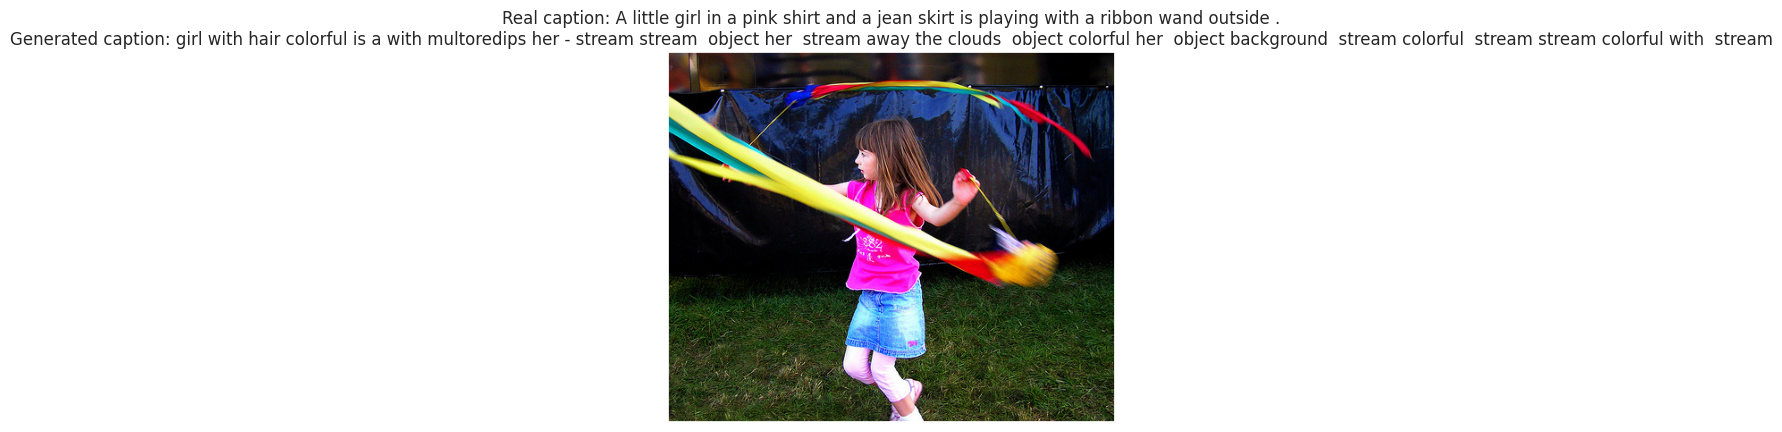

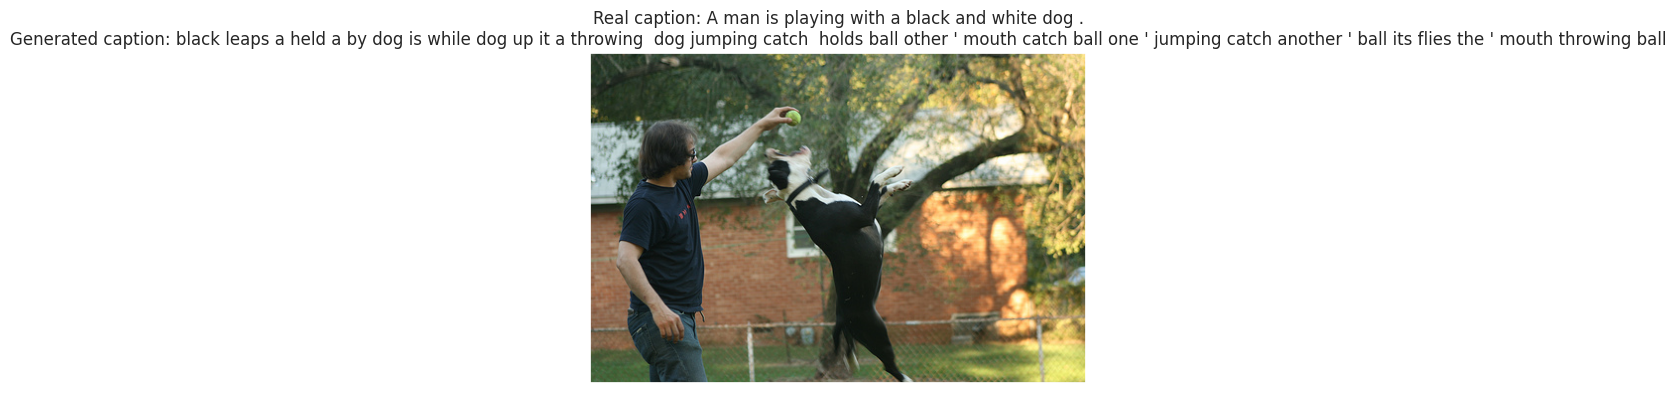

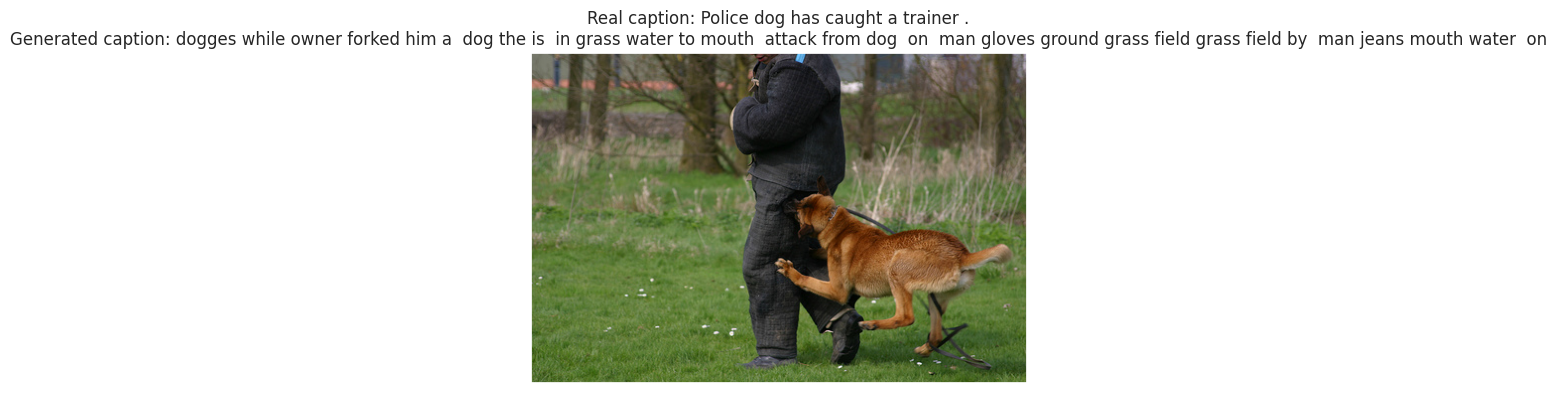

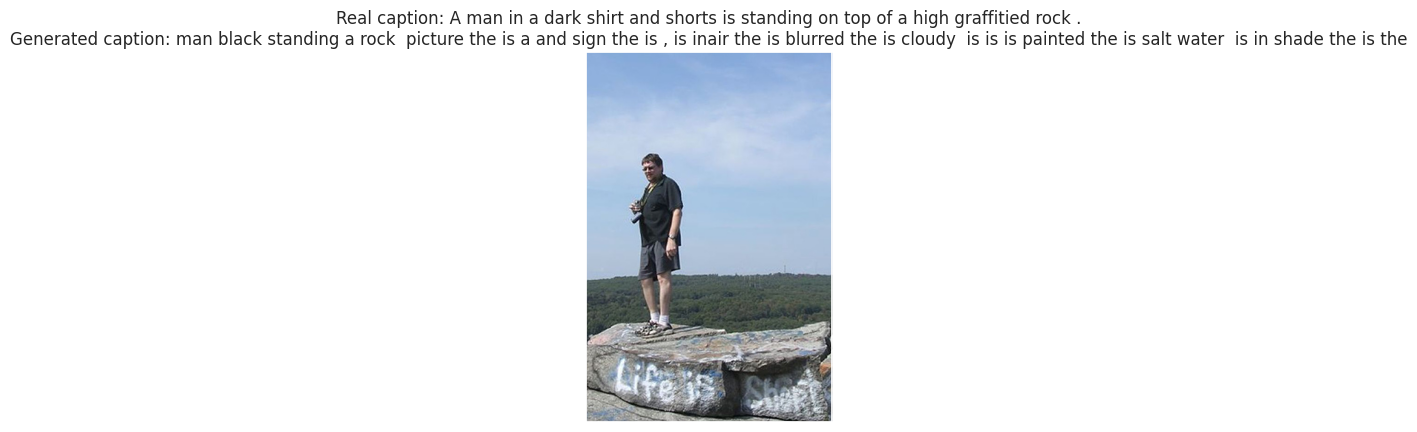

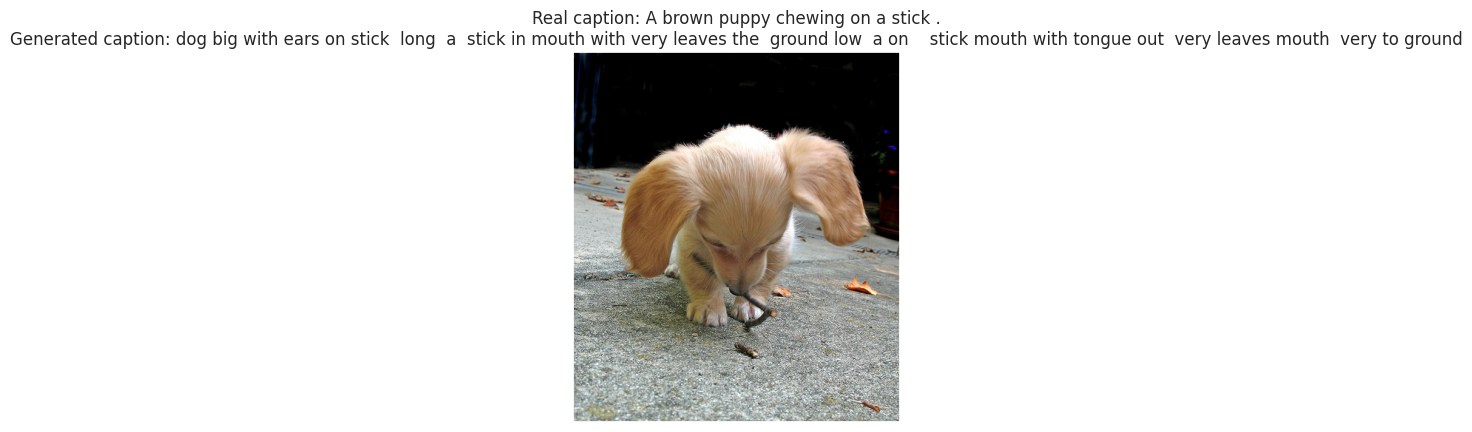

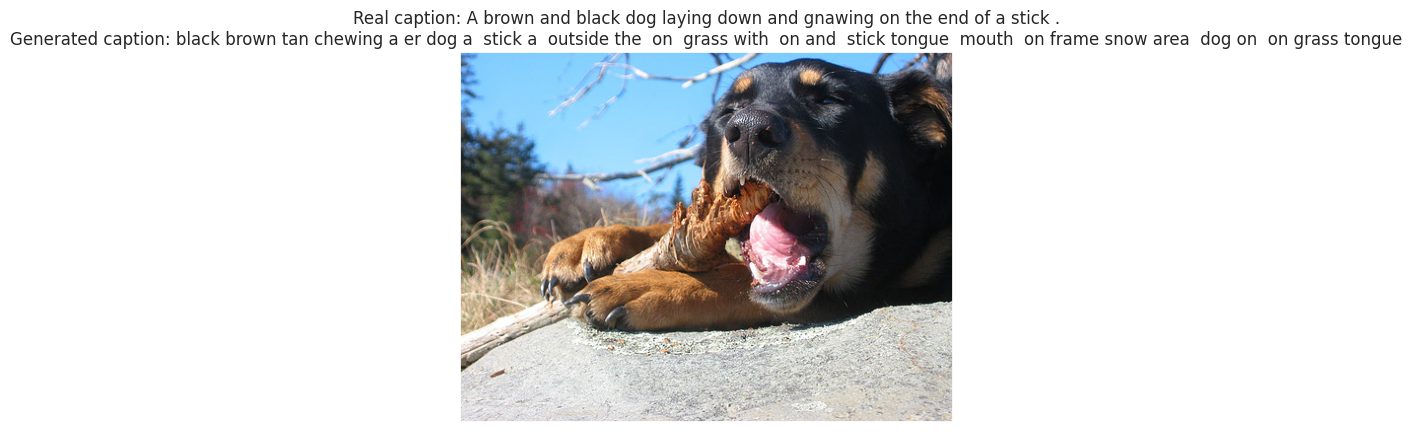

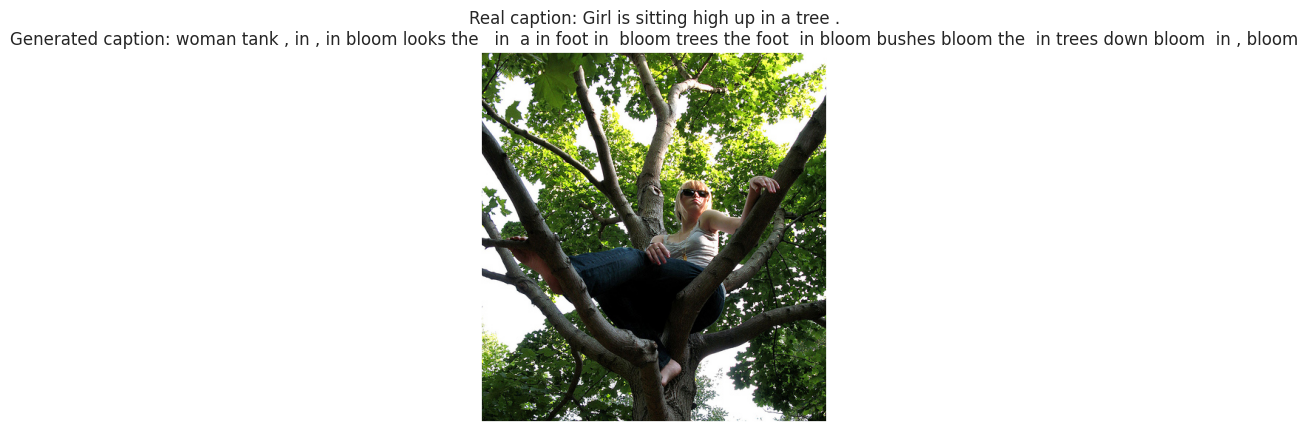

In [ ]:
for i in ids:
    pixel_values = valid_ds[i][0].unsqueeze(0).to(device)
    predictions = tokenizer.decode(model.generate(pixel_values=pixel_values)[0], skip_special_tokens=True)
    fact = valid_df.loc[int(i), 'caption']
    caption = predictions.replace('.', '').strip()

    im = plt.imread(valid_df.iloc[i].image)
    title = f'Real caption: {fact}\nGenerated caption: {caption}'

    plt.imshow(im)
    plt.title(title)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.show()

It looks like the model can capture the content of the images in most cases, but the generated captions contain many mistakes. This confusion likely stems from the model being trained on four different captions for each image. It would be interesting to see if training the model with only one caption per image.

**Conclusions:**

- Model can capture the content on the images
- Cpations are not natural because of different captions for a single image
- It would be a good idea to train a model with one caption for each image for the 1st experiment and one caption for each image in ~6000 images and remaining 2000 for the test and the validation sets.